# Part 1: Single subject classification (subject 1)
## Import required libraries

In [1]:
# Import Required Libraries
import os
import zipfile
import pandas as pd
import seaborn as sns
sns.set()
import scipy.io as sio
from scipy.ndimage import convolve1d
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer, f1_score
from sklearn.feature_selection import SelectKBest, SelectFromModel, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

In [2]:
from functions import *

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

## Load and extract data

In [3]:
# Define the base path to the zip files and the extraction directory
base_zip_path = '../data/'
extraction_dir = '../data/'

# Loop through all 27 subjects
for subject_num in range(1, 28):
    zip_file_path = os.path.join(base_zip_path, f's{subject_num}.zip')
    
    # Extract the zip file
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extraction_dir)
    
    # Define the paths to the .mat files
    mat_file_path_e1 = os.path.join(extraction_dir, f'S{subject_num}_A1_E1.mat')
    mat_file_path_e2 = os.path.join(extraction_dir, f'S{subject_num}_A1_E2.mat')
    mat_file_path_e3 = os.path.join(extraction_dir, f'S{subject_num}_A1_E3.mat')
    
    # Delete the S[subject number]_A1_E2.mat and S[subject number]_A1_E3.mat files
    if os.path.exists(mat_file_path_e2):
        os.remove(mat_file_path_e2)
    if os.path.exists(mat_file_path_e3):
        os.remove(mat_file_path_e3)
    
# Now, specifically work on S2_A1_E1.mat
subject_num = 2
mat_file_path_e1 = os.path.join(extraction_dir, f'S{subject_num}_A1_E1.mat')

# Load the .mat file using scipy.io.loadmat
mat_data = sio.loadmat(mat_file_path_e1)

# Print the keys of the loaded .mat file to see available variables
print(mat_data.keys())

# Extract the data and labels
emg = mat_data['emg']
stimulus = mat_data['restimulus']
repetition = mat_data['rerepetition']

dict_keys(['__header__', '__version__', '__globals__', 'subject', 'exercise', 'stimulus', 'emg', 'glove', 'restimulus', 'repetition', 'rerepetition'])


## Exploration of the data

In [4]:
# Print the shape of the data and labels
print("EMG:", emg.shape)
print("Stimulus:", stimulus.shape)
print("Repetition:", repetition.shape)
print(f"There are {emg.shape[0]} timepoints and {emg.shape[1]} channels.")

n_stimuli = len(np.unique(stimulus)) - 1 # -1 because 0 is the resting condition
n_repetitions = len(np.unique(repetition)) - 1 # -1 because 0 is not a repetition
print(f'There are {n_stimuli} types of movement and {n_repetitions} repetitions.')

EMG: (100686, 10)
Stimulus: (100686, 1)
Repetition: (100686, 1)
There are 100686 timepoints and 10 channels.
There are 12 types of movement and 10 repetitions.


In [5]:
# How many samples (or timesteps) has each trial?
n_samples = np.zeros((n_stimuli, n_repetitions))

for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):
        idx  =np.logical_and(stimulus == stimuli_idx+1, repetition == repetition_idx+1)
        n_samples[stimuli_idx, repetition_idx] = np.sum(idx.astype(int))
n_samples

array([[307., 390., 262., 226., 418., 204., 196., 270., 306., 489.],
       [334., 323., 344., 309., 333., 376., 362., 307., 348., 339.],
       [465., 352., 450., 460., 436., 389., 323., 388., 383., 316.],
       [310., 402., 357., 396., 255., 333., 263., 369., 438., 471.],
       [516., 382., 425., 379., 463., 411., 387., 343., 286., 377.],
       [337., 319., 337., 368., 338., 336., 268., 354., 319., 313.],
       [428., 392., 341., 393., 421., 445., 342., 328., 329., 358.],
       [289., 372., 406., 397., 498., 336., 415., 328., 472., 405.],
       [384., 424., 371., 316., 280., 314., 342., 284., 307., 421.],
       [311., 296., 299., 296., 301., 246., 213., 317., 493., 221.],
       [352., 403., 338., 416., 330., 355., 313., 322., 329., 219.],
       [270., 330., 300., 387., 295., 204., 363., 267., 281., 329.]])

## Visualize raw EMG data

In [6]:
mov_mean_length = 25
mov_mean_weights = np.ones(mov_mean_length) / mov_mean_length

# Initializing the data structure
emg_windows = [[None for repetition_idx in range(n_repetitions)] for stimuli_idx in range(n_stimuli)]
emg_envelopes = [[None for repetition_idx in range(n_repetitions)] for stimuli_idx in range(n_stimuli)]

for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):
        idx  =np.logical_and(stimulus == stimuli_idx+1, repetition == repetition_idx+1).flatten()
        emg_windows[stimuli_idx][repetition_idx] = emg[idx, :]
        emg_envelopes[stimuli_idx][repetition_idx] = convolve1d(emg_windows[stimuli_idx][repetition_idx], mov_mean_weights, axis=0)

/var/folders/q_/xhgs30s966s2xsy_tl8w2k680000gp/T/ipykernel_76031/196830994.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', emg.shape[1]) # Define a color map


Text(0.5, 0.98, 'Envelopes of the EMG signal')

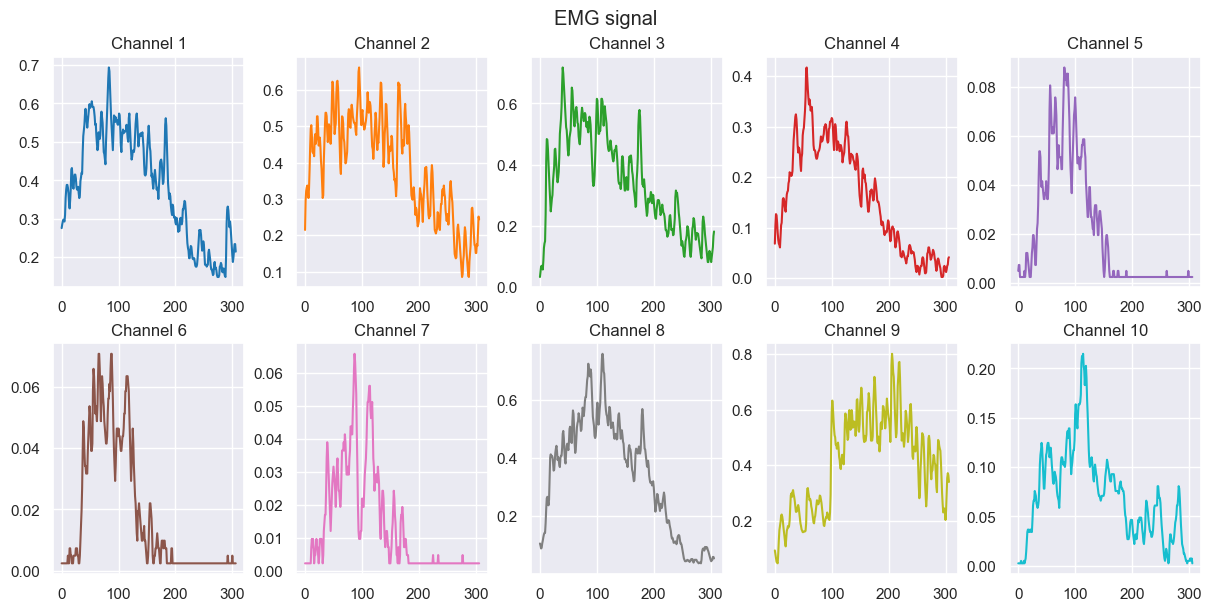

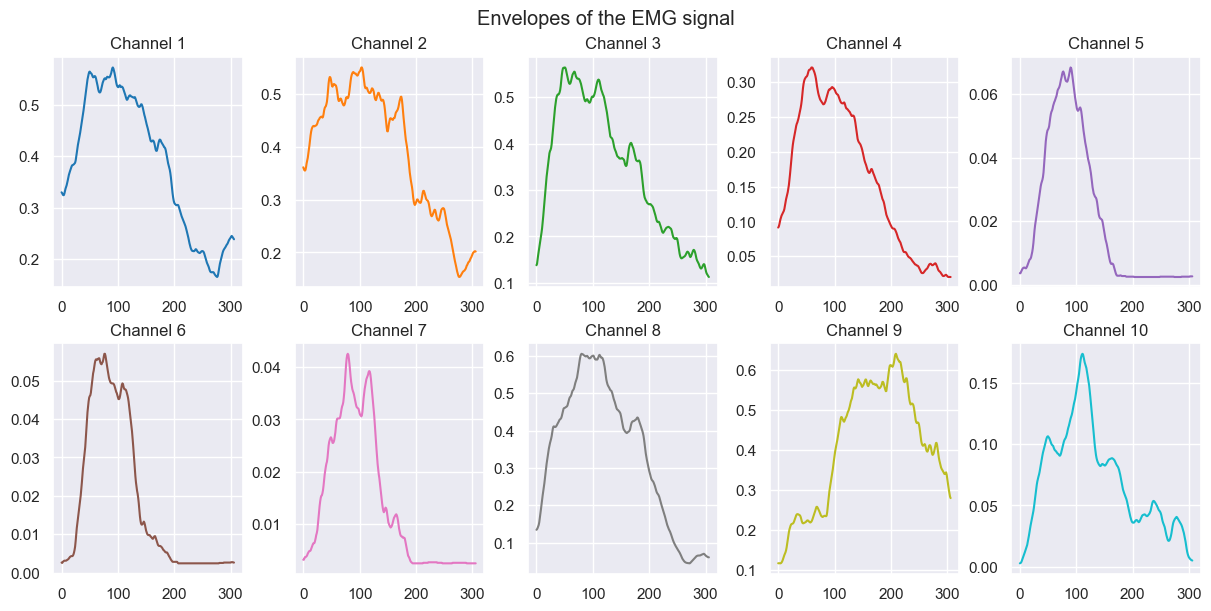

In [7]:
colors = plt.cm.get_cmap('tab10', emg.shape[1]) # Define a color map
n_channels = emg.shape[-1]

# EMG signal
fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout = True)
ax = ax.ravel()
for channel_idx in range(n_channels):
    ax[channel_idx].plot(emg_windows[0][0][:, channel_idx], color=colors(channel_idx))
    ax[channel_idx].set_title(f'Channel {channel_idx + 1}')
plt.suptitle("EMG signal")

# Envelopes of the EMG signal
fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout = True)
ax = ax.ravel()
for channel_idx in range(n_channels):
    ax[channel_idx].plot(emg_envelopes[0][0][:, channel_idx], color=colors(channel_idx))
    ax[channel_idx].set_title(f'Channel {channel_idx + 1}')
plt.suptitle("Envelopes of the EMG signal")

To detect potential anomalies, we now want to plot all the channels with the same y axis:

Text(0.5, 0.98, 'Envelopes of the EMG signal')

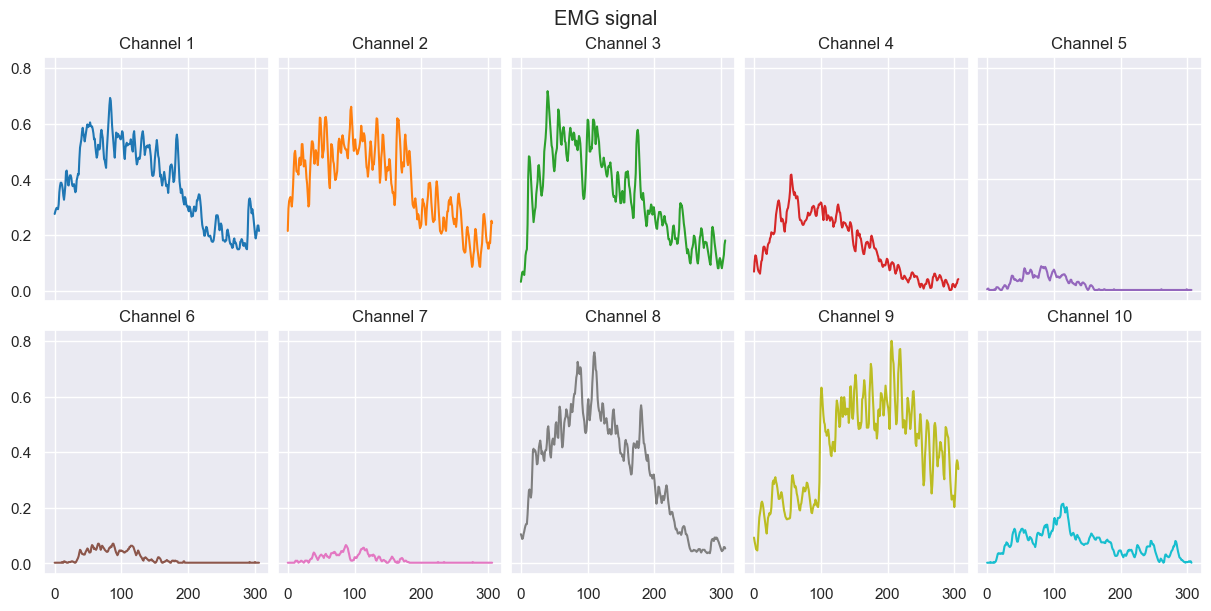

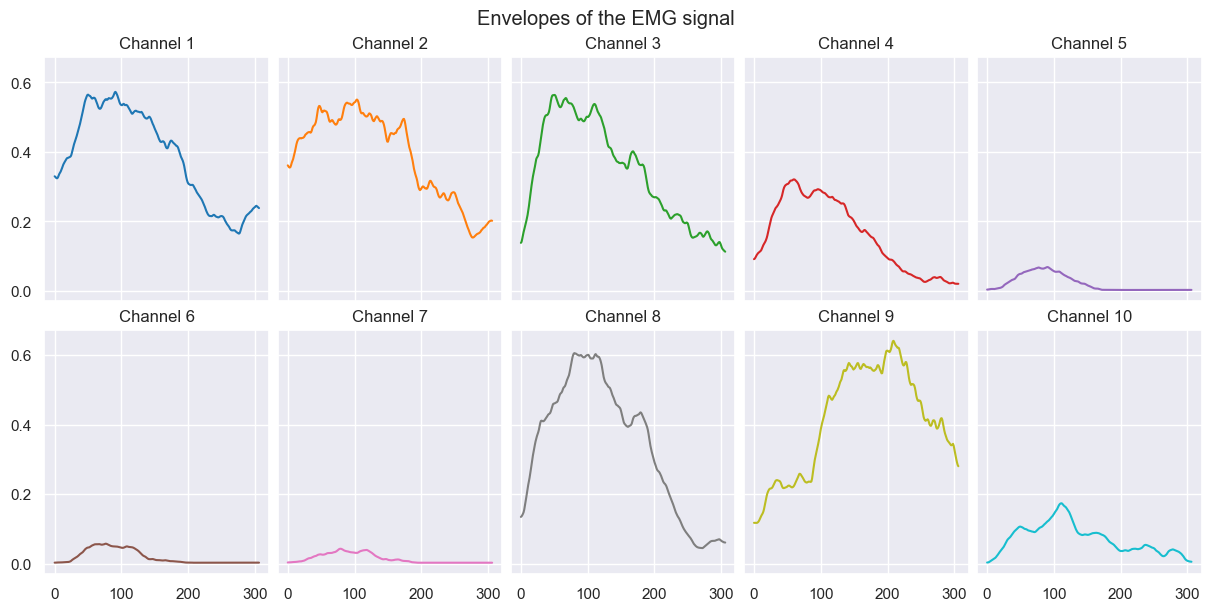

In [8]:
n_channels = emg.shape[-1]

# EMG signal
fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout = True, sharex=True, sharey=True)
ax = ax.ravel()
for channel_idx in range(n_channels):
    ax[channel_idx].plot(emg_windows[0][0][:, channel_idx], color=colors(channel_idx))
    ax[channel_idx].set_title(f'Channel {channel_idx + 1}')
plt.suptitle("EMG signal")

# Envelopes of the EMG signal
fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout = True, sharex=True, sharey=True)
ax = ax.ravel()
for channel_idx in range(n_channels):
    ax[channel_idx].plot(emg_envelopes[0][0][:, channel_idx], color=colors(channel_idx))
    ax[channel_idx].set_title(f'Channel {channel_idx + 1}')
plt.suptitle("Envelopes of the EMG signal")

The channels 1, 2, 3, 8 and 9 seem to have similar amplitudes, therefore we don't want to discard these channels, even though they might overpower the channels 5, 6 and 7.

## Visualization across repetitions

In [9]:
emg_average_activations = np.zeros((n_channels, n_stimuli, n_repetitions))
for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):
        # Mean across time
        emg_average_activations[:, stimuli_idx, repetition_idx] = np.mean(emg_envelopes[stimuli_idx][repetition_idx], axis=0)

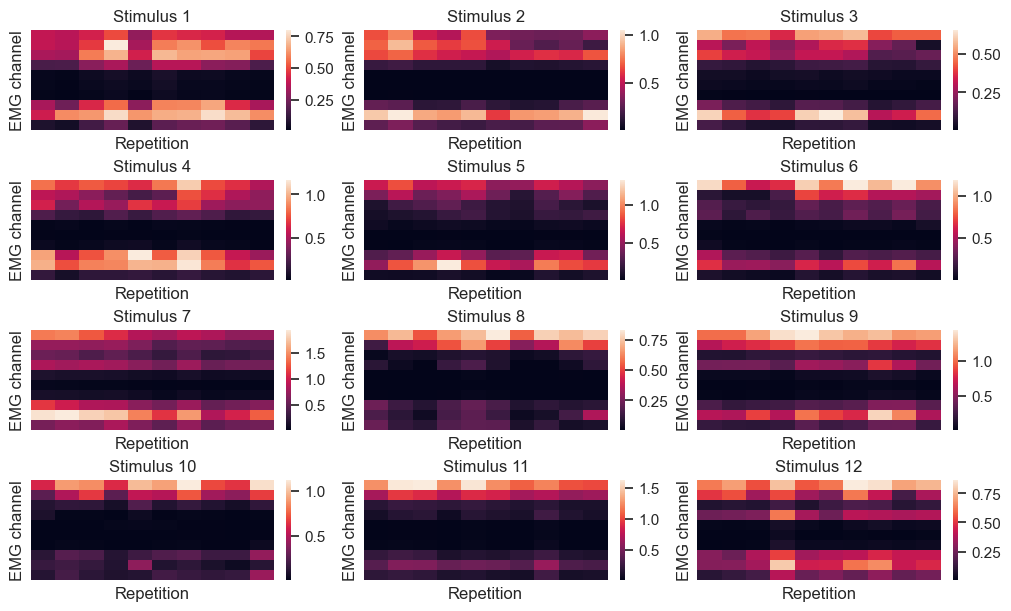

In [10]:
fig, ax = plt.subplots(4, 3, figsize=(10, 6), constrained_layout = True, sharex=True, sharey=True)
ax = ax.ravel()
for stimuli_idx in range(n_stimuli):
    sns.heatmap(np.squeeze(emg_average_activations[:, stimuli_idx, :]), ax = ax[stimuli_idx], xticklabels=False, yticklabels=False, cbar = True)
    ax[stimuli_idx].title.set_text("Stimulus " + str(stimuli_idx + 1))
    ax[stimuli_idx].set_xlabel("Repetition")
    ax[stimuli_idx].set_ylabel("EMG channel")

- Homogeneous by row: each channel is exposed to the same activity and captures similar muscular activity
- Variability across columns: Different muscles are not equally activated with each stimulus repetition (physiology + impedance)\\

Channels 5, 6 and 7 are overpowered by the other channels -> normalization
- Variability across stimuli: different stimuli cause activation in different muscle groups 

## Preprocess EMG data

#### Z-Score normaliaztion

In [11]:
# Z-score normalization for each channel
normalized_emg_data = (emg - np.mean(emg, axis=0)) / np.std(emg, axis=0)

In [12]:
n_emg_windows = [[None for repetition_idx in range(n_repetitions)] for stimuli_idx in range(n_stimuli)]
n_emg_envelopes = [[None for repetition_idx in range(n_repetitions)] for stimuli_idx in range(n_stimuli)]

for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):
        idx  =np.logical_and(stimulus == stimuli_idx+1, repetition == repetition_idx+1).flatten()
        n_emg_windows[stimuli_idx][repetition_idx] = normalized_emg_data[idx, :]
        n_emg_envelopes[stimuli_idx][repetition_idx] = convolve1d(n_emg_windows[stimuli_idx][repetition_idx], mov_mean_weights, axis=0)

n_emg_average_activations = np.zeros((n_channels, n_stimuli, n_repetitions))
for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):
        # Mean across time
        n_emg_average_activations[:, stimuli_idx, repetition_idx] = np.mean(n_emg_envelopes[stimuli_idx][repetition_idx], axis=0)

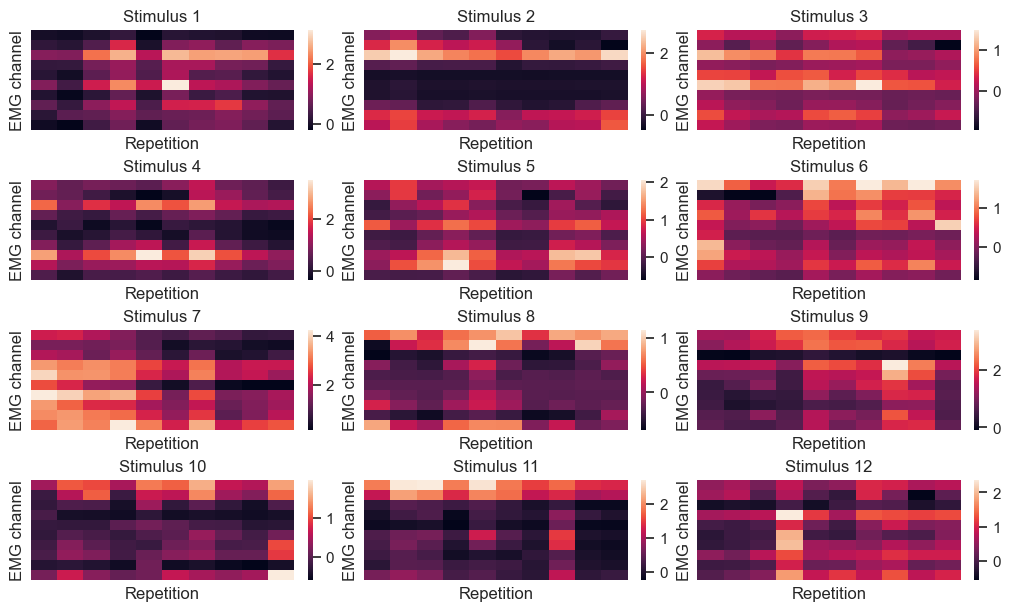

In [13]:
fig, ax = plt.subplots(4, 3, figsize=(10, 6), constrained_layout = True, sharex=True, sharey=True)
ax = ax.ravel()
for stimuli_idx in range(n_stimuli):
    sns.heatmap(np.squeeze(n_emg_average_activations[:, stimuli_idx, :]), ax = ax[stimuli_idx], xticklabels=False, yticklabels=False, cbar = True)
    ax[stimuli_idx].title.set_text("Stimulus " + str(stimuli_idx + 1))
    ax[stimuli_idx].set_xlabel("Repetition")
    ax[stimuli_idx].set_ylabel("EMG channel")

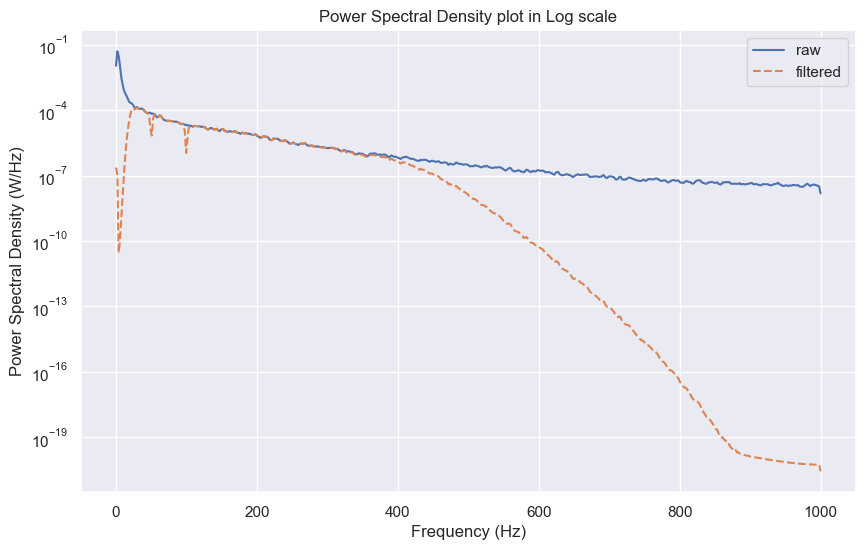

In [14]:
# Apply bandpass filter to the data
emg_filtered = bandpass_filter(emg)
fs = 2000.0 # Sampling frequency

# Plot the power spectrum of the first channel in log scale
freqs_pre, Pxx_pre = welch(emg[:, 0], fs, nperseg=1064)
freqs_post, Pxx_post = welch(emg_filtered[:, 0], fs, nperseg=1064)

# Plot the power spectrum in log scale
plt.figure(figsize=(10, 6))
plt.semilogy(freqs_pre, Pxx_pre, label="raw")
plt.semilogy(freqs_post, Pxx_post, linestyle="--", label="filtered")
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (W/Hz)')
plt.title('Power Spectral Density plot in Log scale')
plt.show()

# Rectify the signal
emg_rectified = np.abs(emg_filtered)

# Envelop the signal using a moving average filter
mov_mean_size = 200
mov_mean_weights = np.ones(mov_mean_size) / mov_mean_size
emg_envelopes = convolve1d(emg_rectified, weights=mov_mean_weights, axis=0) # convolve1d the rectified signal with the moving average weights

**Question:** 

Does the data look reasonable? Did you need to remove any trials?

**Answer:** 

The data look reasonable, we did not remove any trials. **[TO COMPLETE]**

## Split the data into training, validation, and testing sets

In [15]:
labels = stimulus

# Define the split ratio
train_ratio = 0.8
test_ratio = 0.2

# Split the data into training and test sets
data_train, data_test, labels_train, labels_test = train_test_split(emg, labels, test_size=test_ratio, random_state=42)

# Display the shapes of the datasets
data_info = {
    "Dataset": ["Training", "Testing"],
    "Data Shape": [data_train.shape, data_test.shape],
    "Labels Shape": [labels_train.shape, labels_test.shape]
}
df = pd.DataFrame(data_info)
print(df)

# Perform cross-validation with cv=5 when training the model
# Example: cross_validate(clf, data_train, labels_train, cv=5, scoring=scoring)

    Dataset   Data Shape Labels Shape
0  Training  (80548, 10)   (80548, 1)
1   Testing  (20138, 10)   (20138, 1)


**Question:** 

Why do we need the different datasets?

**Answer:** 

Different datasets are used to ensure a machine learning model generalizes well to new data. The training set is used to learn and adjust model parameters. The testing set provides an unbiased evaluation of the final model's performance on unseen data. During model training, cross-validation (e.g., with cv=5) is used to further split the training set into training and validation subsets. This helps tune hyperparameters and select the best model configuration. This approach helps prevent overfitting and ensures the model performs well in real-world applications.

## Extract features from the trials

In [16]:
# Build the dataset and labels
dataset, labels = build_dataset_from_ninapro(
    emg=emg,
    stimulus=stimulus,
    repetition=repetition,
    features=[mav, std, maxav, rms, wl, ssc, mean_frequency, total_power],
)

print(f"Dataset dimension: {dataset.shape}")
print(f"Labels dimension: {labels.shape}")

/opt/anaconda3/lib/python3.12/site-packages/scipy/signal/_spectral_py.py:600: UserWarning: nperseg = 256 is greater than input length  = 226, using nperseg = 226
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/opt/anaconda3/lib/python3.12/site-packages/scipy/signal/_spectral_py.py:600: UserWarning: nperseg = 256 is greater than input length  = 204, using nperseg = 204
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/opt/anaconda3/lib/python3.12/site-packages/scipy/signal/_spectral_py.py:600: UserWarning: nperseg = 256 is greater than input length  = 196, using nperseg = 196
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/opt/anaconda3/lib/python3.12/site-packages/scipy/signal/_spectral_py.py:600: UserWarning: nperseg = 256 is greater than input length  = 255, using nperseg = 255
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/opt/anaconda3/lib/python3.12/site-packages/scipy/signal/_spectr

Dataset dimension: (120, 80)
Labels dimension: (120,)


### Look at the typical values of the features across the different trials

In [17]:
# Use the dataset in place of features
num_trials, num_features = dataset.shape
num_channels = emg.shape[1]  # Number of channels
num_feature_types = num_features // num_channels  # Number of feature types

# Generate feature names
feature_types = ['MAV', 'STD', 'MaxAV', 'RMS', 'WL', 'SSC', 'MeanFrequency', 'TotalPower']
feature_names = []
for i in range(num_channels):
    for feature_type in feature_types:
        feature_names.append(f'{feature_type}_{i+1}')

# Convert the dataset to a DataFrame for easier analysis
features_df = pd.DataFrame(dataset, columns=feature_names)

# Compute and print summary statistics
summary_stats = features_df.describe()
print(summary_stats)

            MAV_1       STD_1     MaxAV_1       RMS_1        WL_1       SSC_1  \
count  120.000000  120.000000  120.000000  120.000000  120.000000  120.000000   
mean     0.785619    0.334891    1.504780    0.857988   11.022289  114.158333   
std      0.320491    0.156158    0.633403    0.346767    3.966378   24.417928   
min      0.292367    0.066853    0.532200    0.323726    3.330100   59.000000   
25%      0.546918    0.200188    1.073575    0.590836    8.465425   98.750000   
50%      0.720820    0.334517    1.442850    0.801747   10.594600  112.500000   
75%      1.010312    0.433284    1.840225    1.088319   13.311775  128.000000   
max      1.640325    0.852318    3.864700    1.817505   22.141900  181.000000   

       MeanFrequency_1  TotalPower_1       MAV_2       STD_2  ...  \
count       120.000000    120.000000  120.000000  120.000000  ...   
mean         31.356130      0.011798    0.508316    0.204156  ...   
std          14.535724      0.014863    0.223031    0.080539  .

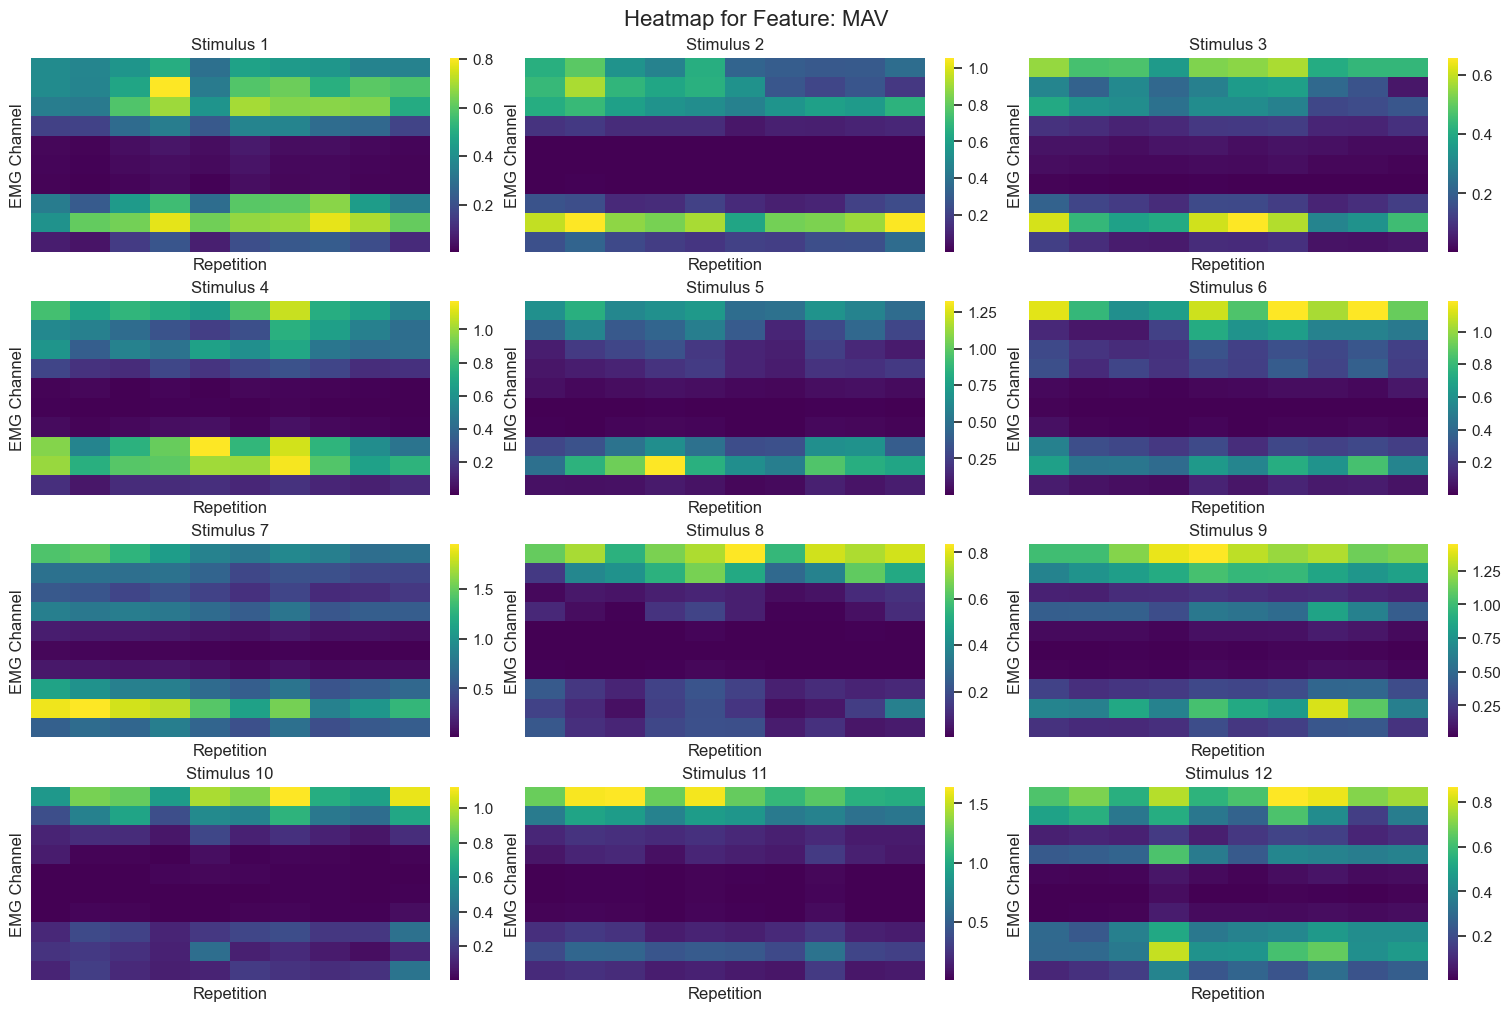

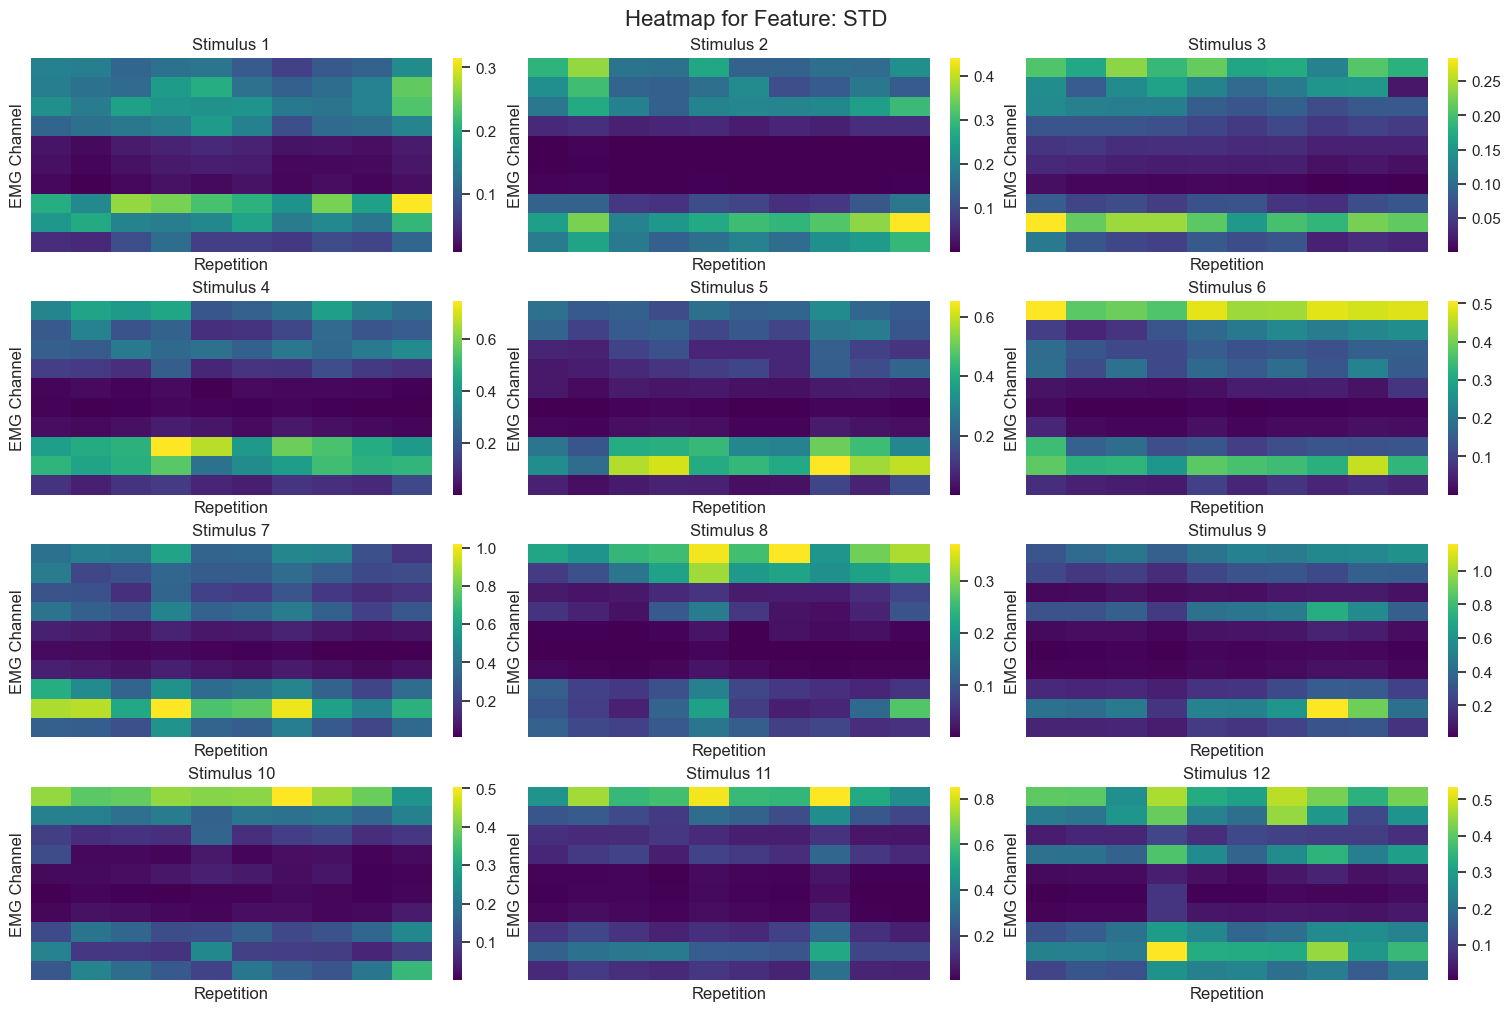

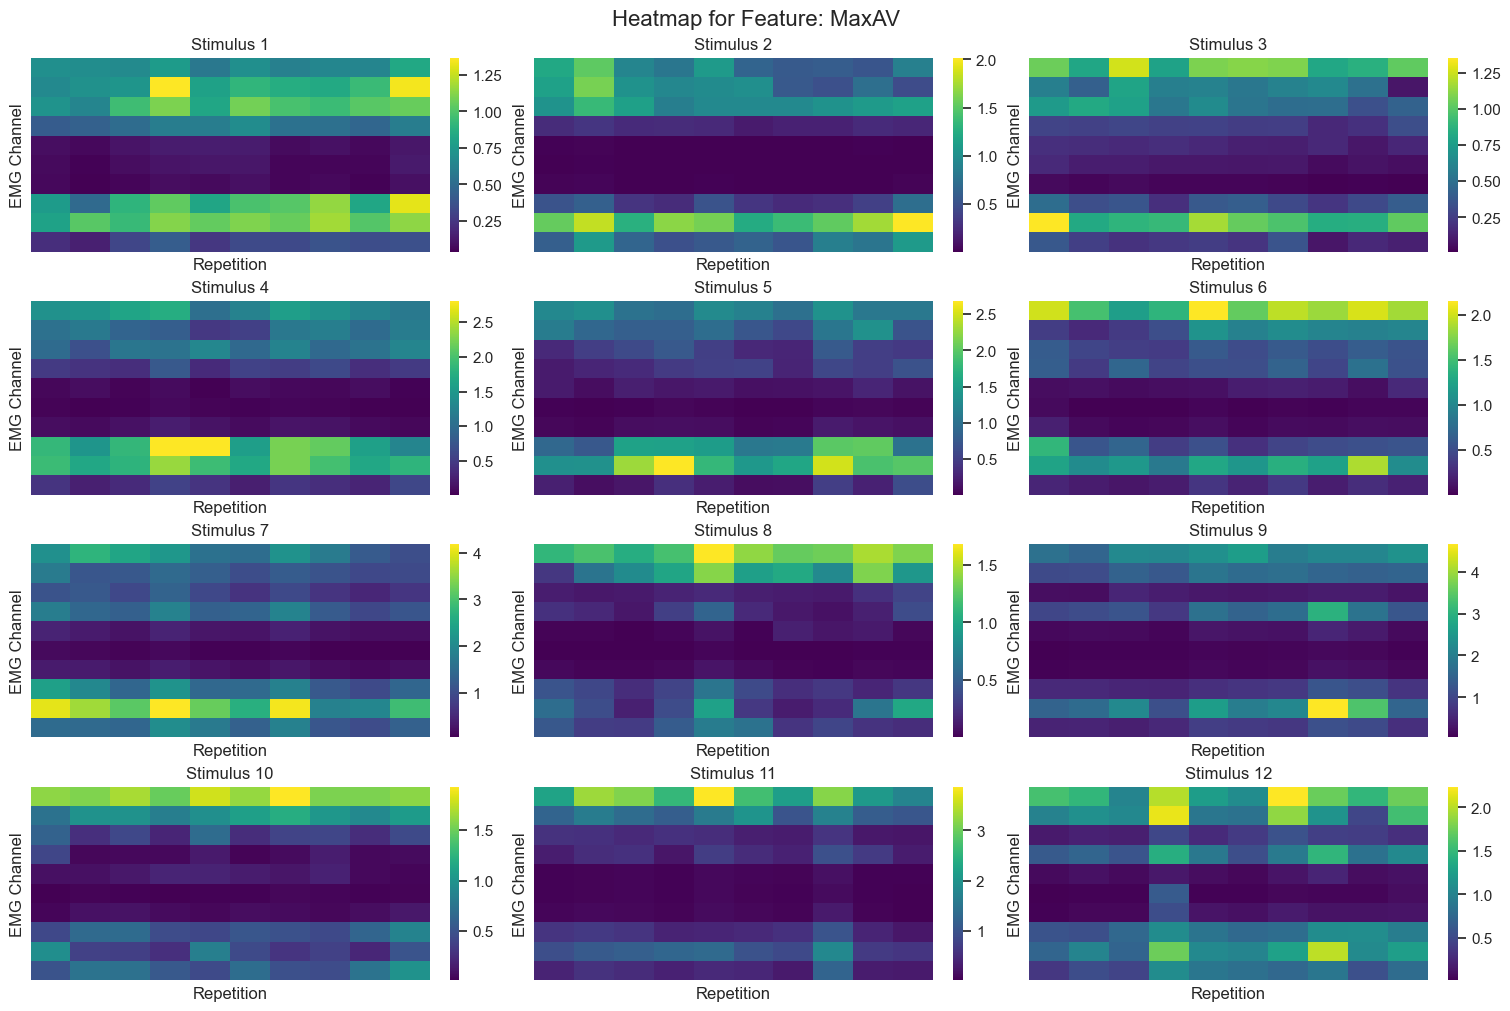

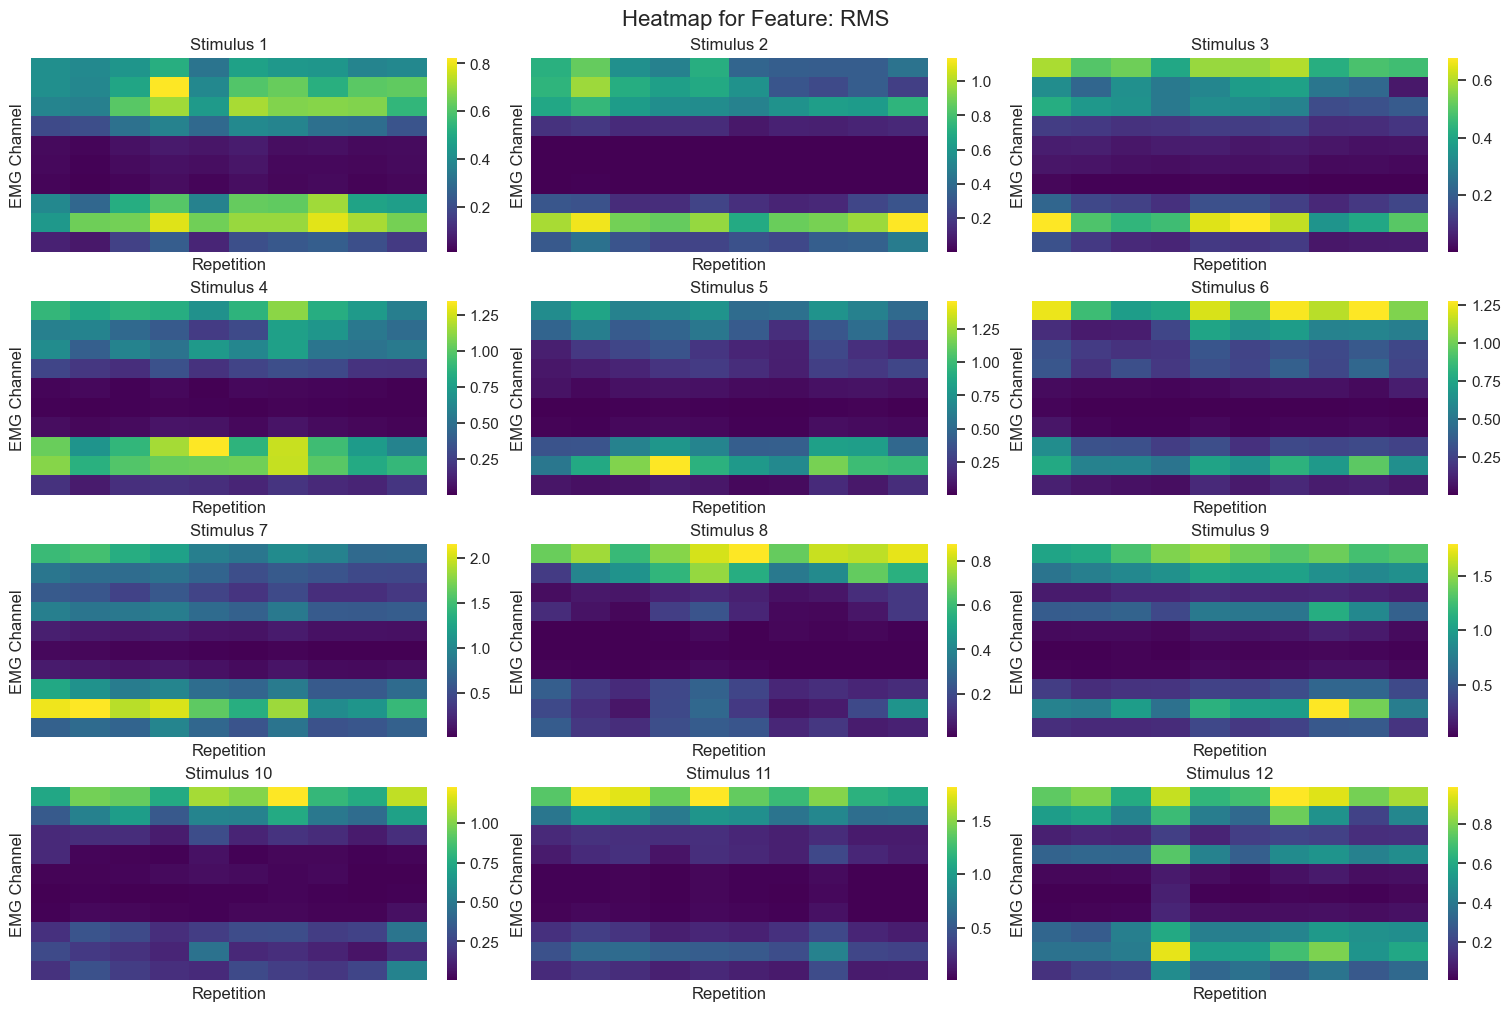

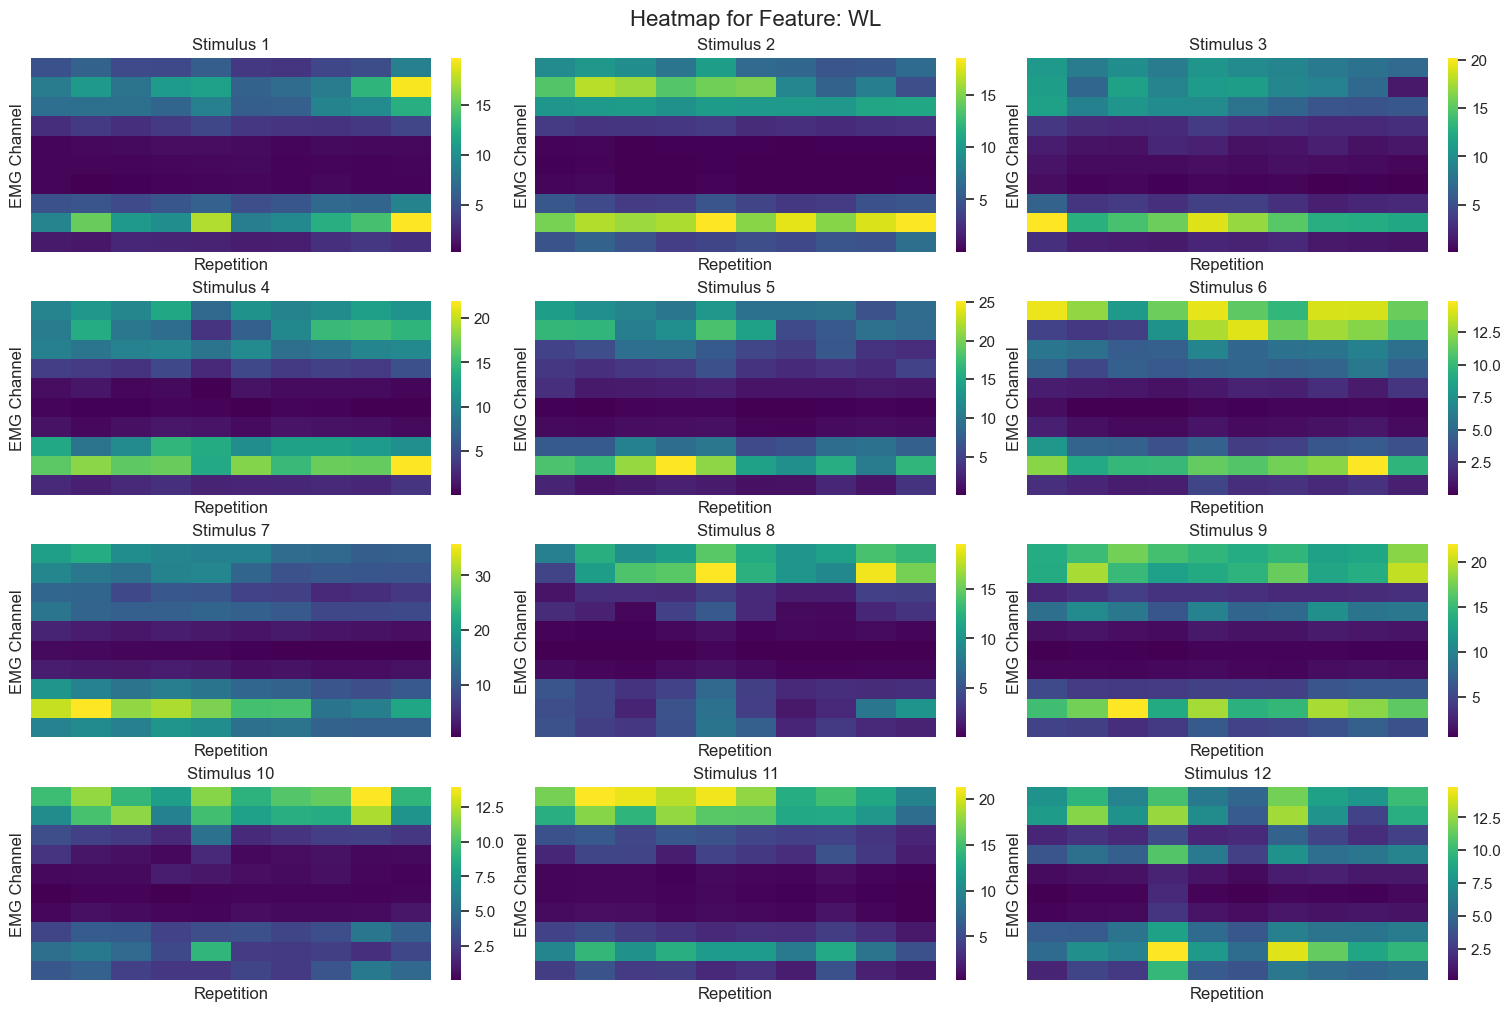

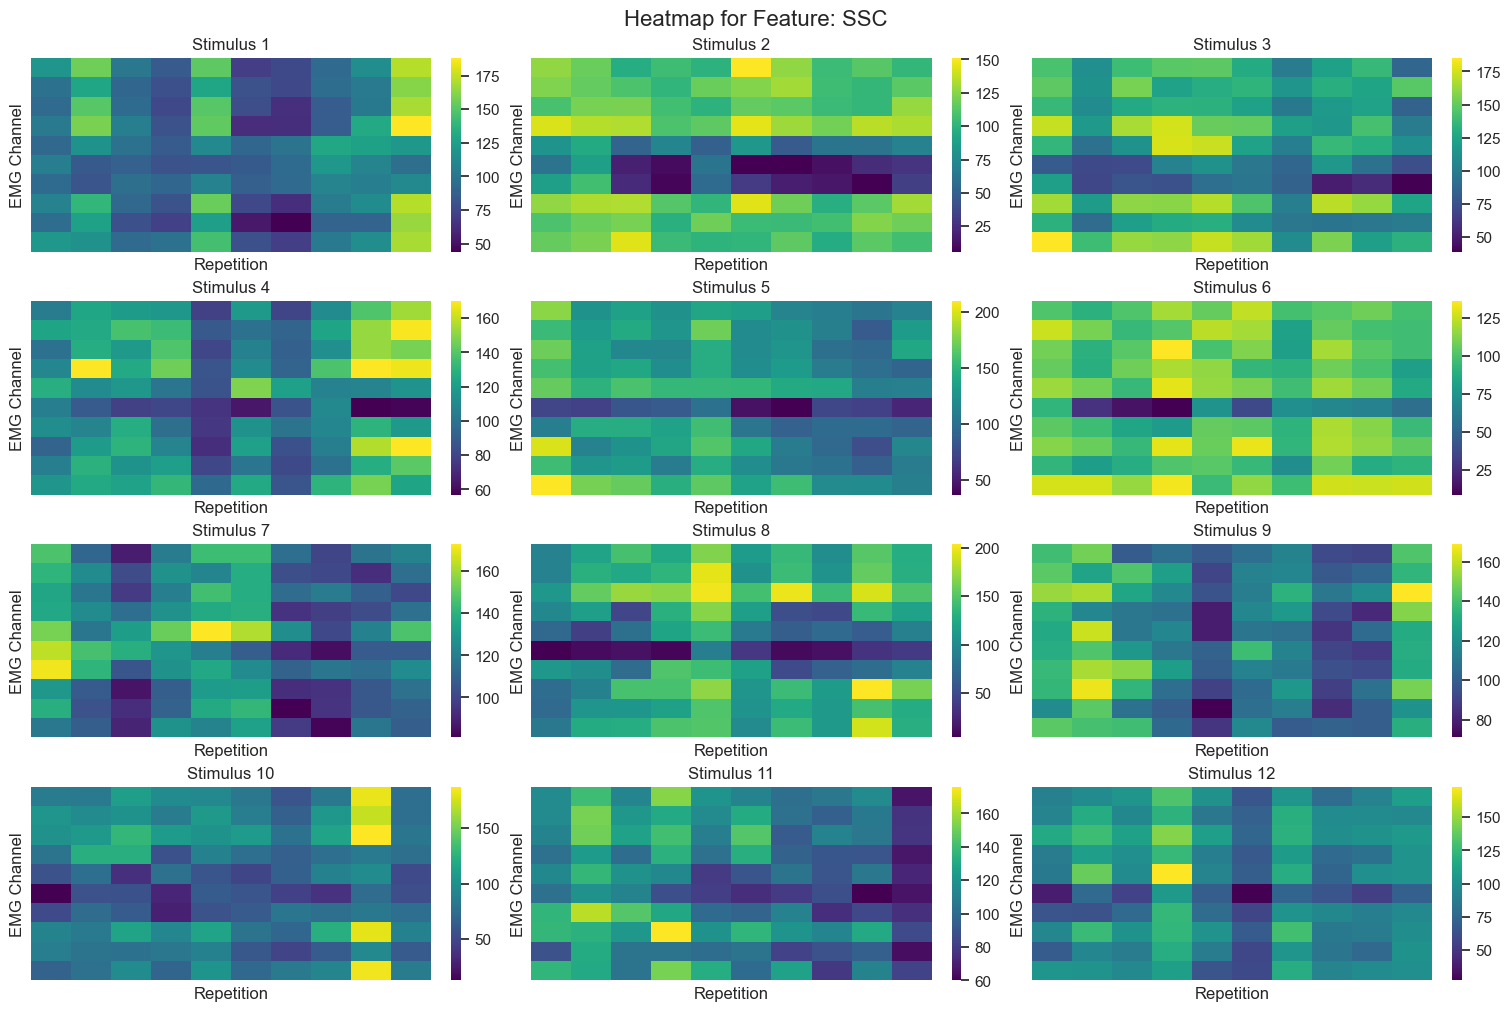

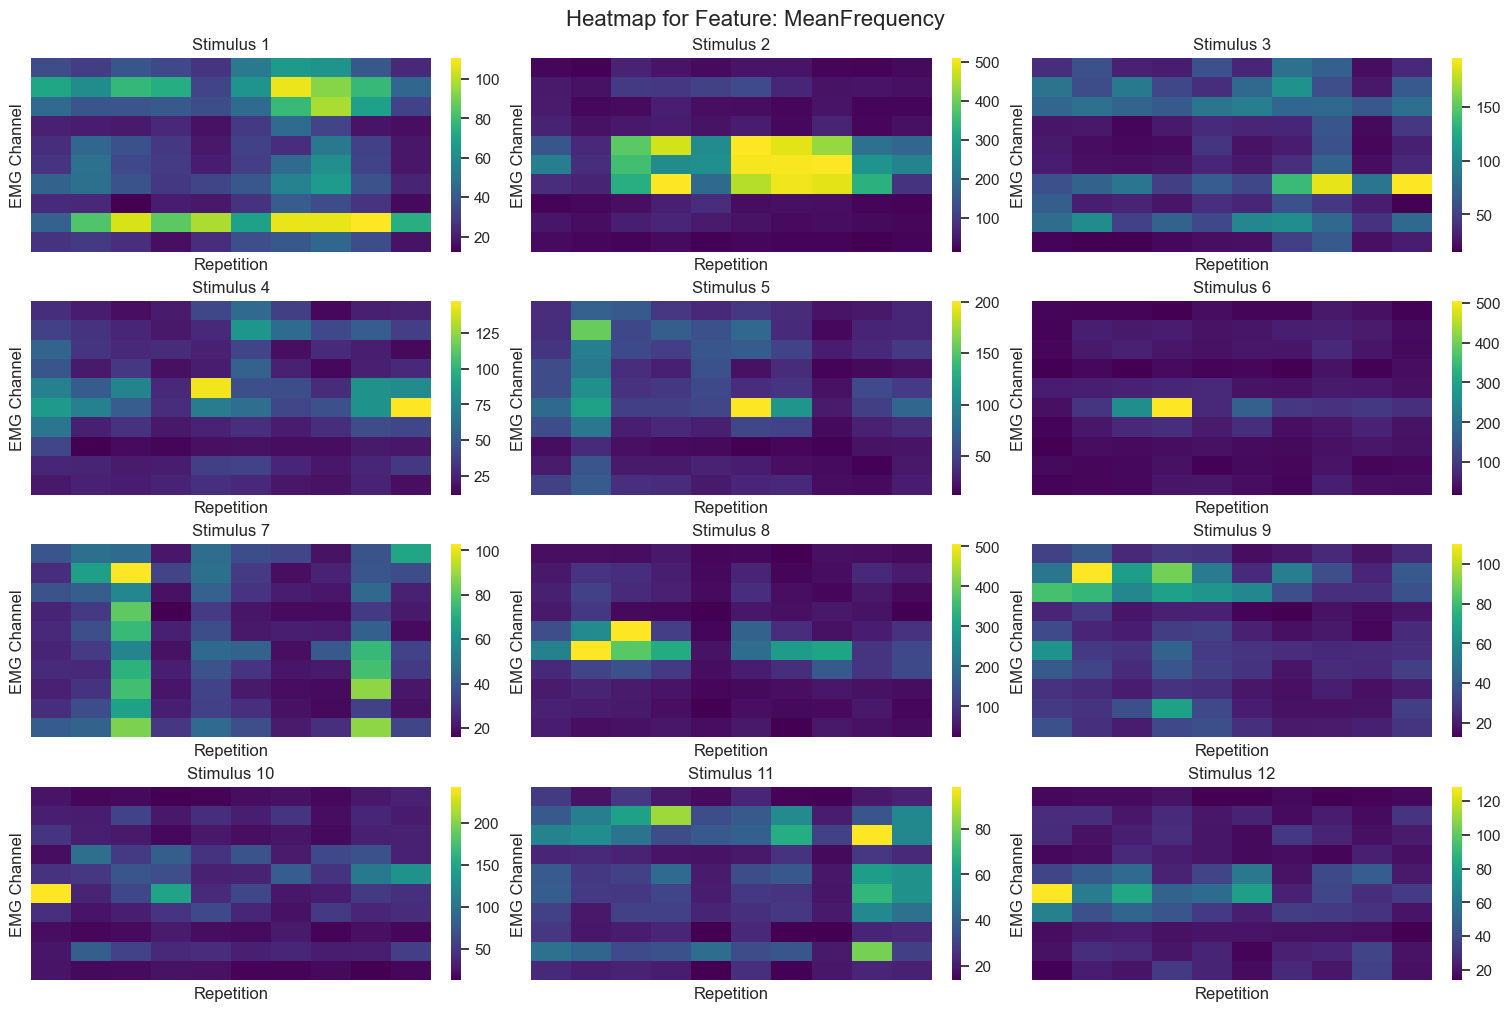

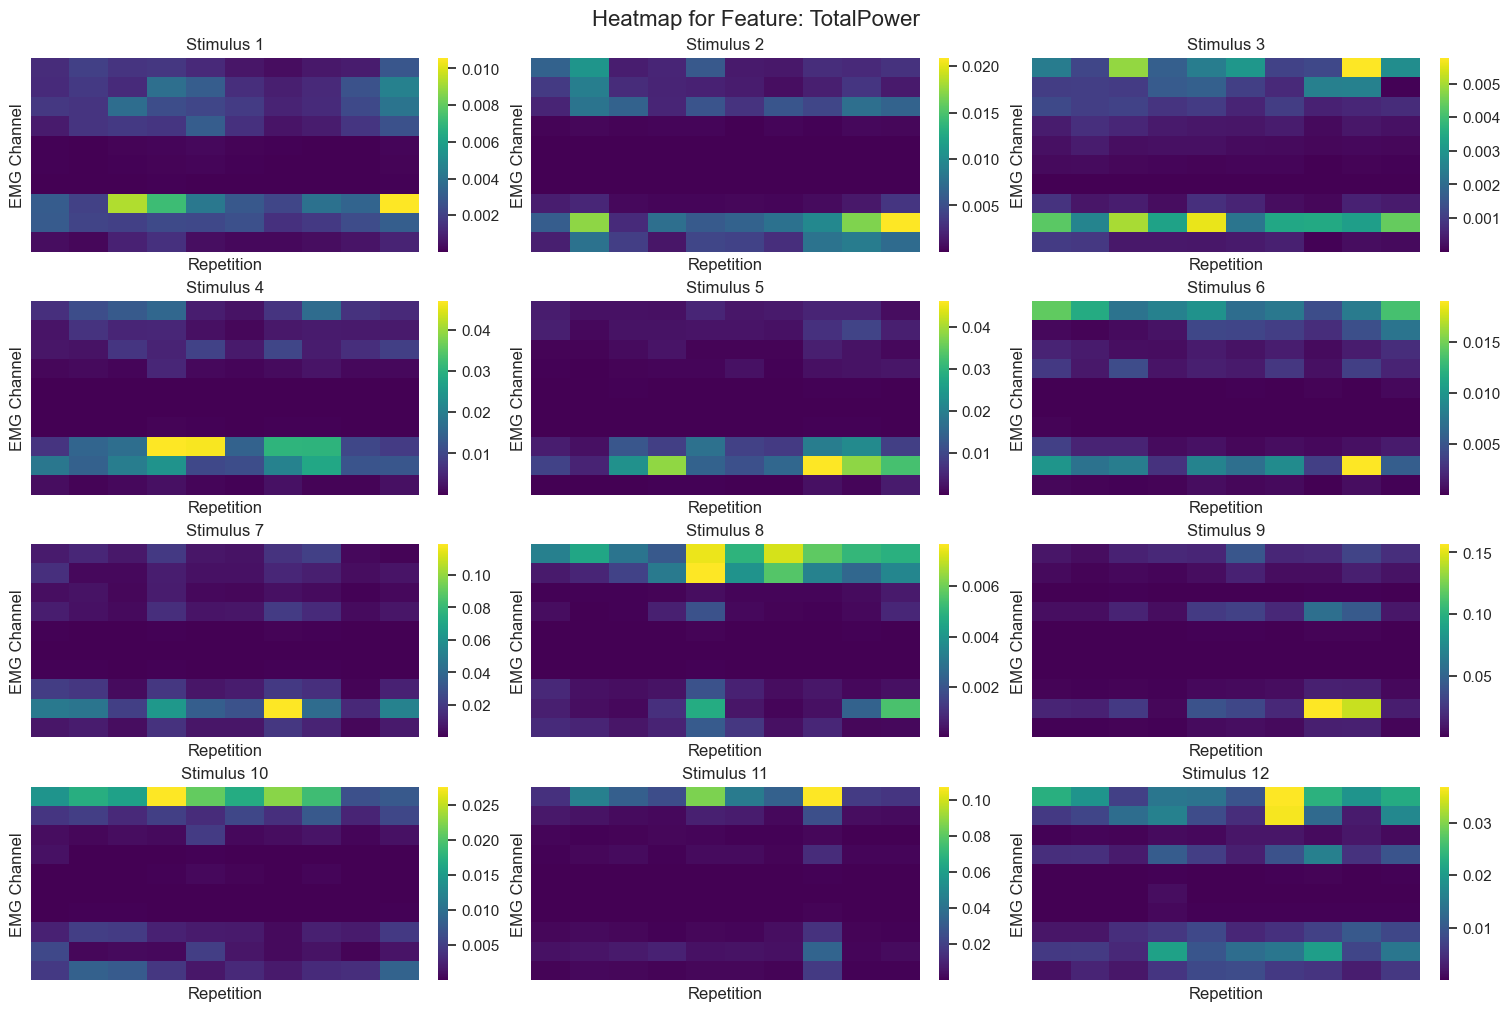

In [19]:
# Use the dataset in place of features
n_trials, n_features = dataset.shape
n_channels = emg.shape[1]  # Number of channels
n_feature_types = n_features // n_channels  # Number of feature types

# Reshape dataset into (num_trials, n_channels, n_features_types)
reshaped_dataset = dataset.reshape(n_trials, n_channels, n_feature_types)

# Generate feature names
feature_names = ["MAV", "STD", "MaxAV", "RMS", "WL", "SSC", "MeanFrequency", "TotalPower"]

# Plot heatmaps for each feature across stimuli
for feature_idx, feature_name in enumerate(feature_names):
    feature_data = reshaped_dataset[:, :, feature_idx]  # Shape (num_trials, num_channels)
    
    # Reshape to (n_stimuli, n_repetitions, num_channels)
    n_stimuli = len(np.unique(labels)) 
    n_repetitions = n_trials // n_stimuli
    feature_data = feature_data.reshape(n_stimuli, n_repetitions, num_channels)
    
    fig, ax = plt.subplots(4, 3, figsize=(15, 10), constrained_layout=True, sharex=True, sharey=True)
    ax = ax.ravel()

    for stimuli_idx in range(n_stimuli):
        sns.heatmap(
            np.transpose(feature_data[stimuli_idx, :, :]),  # Transpose to get channels on y-axis and repetitions on x-axis
            ax=ax[stimuli_idx],
            xticklabels=False,
            yticklabels=False,
            cbar=True,
            cmap="viridis"
        )
        ax[stimuli_idx].title.set_text(f"Stimulus {stimuli_idx + 1}")
        ax[stimuli_idx].set_xlabel("Repetition")
        ax[stimuli_idx].set_ylabel("EMG Channel")

    fig.suptitle(f"Heatmap for Feature: {feature_name}", fontsize=16)
    plt.show()

/var/folders/q_/xhgs30s966s2xsy_tl8w2k680000gp/T/ipykernel_76031/2687237458.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.errorbar(j, summary_stats.loc['mean'][index], yerr=summary_stats.loc['std'][index], fmt='o', ecolor=colors(j), capsize=5, label=f'Channel {j+1}' if i == 0 else "")
/var/folders/q_/xhgs30s966s2xsy_tl8w2k680000gp/T/ipykernel_76031/2687237458.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.errorbar(j, summary_stats.loc['mean'][index], yerr=summary_stats.loc['std'][index], fmt='o', ecolor=colors(j), capsize=5, label=f'Channel {j+1}' if i == 0 else "")
/var/folders/q_/xhgs30s966s2xsy_tl

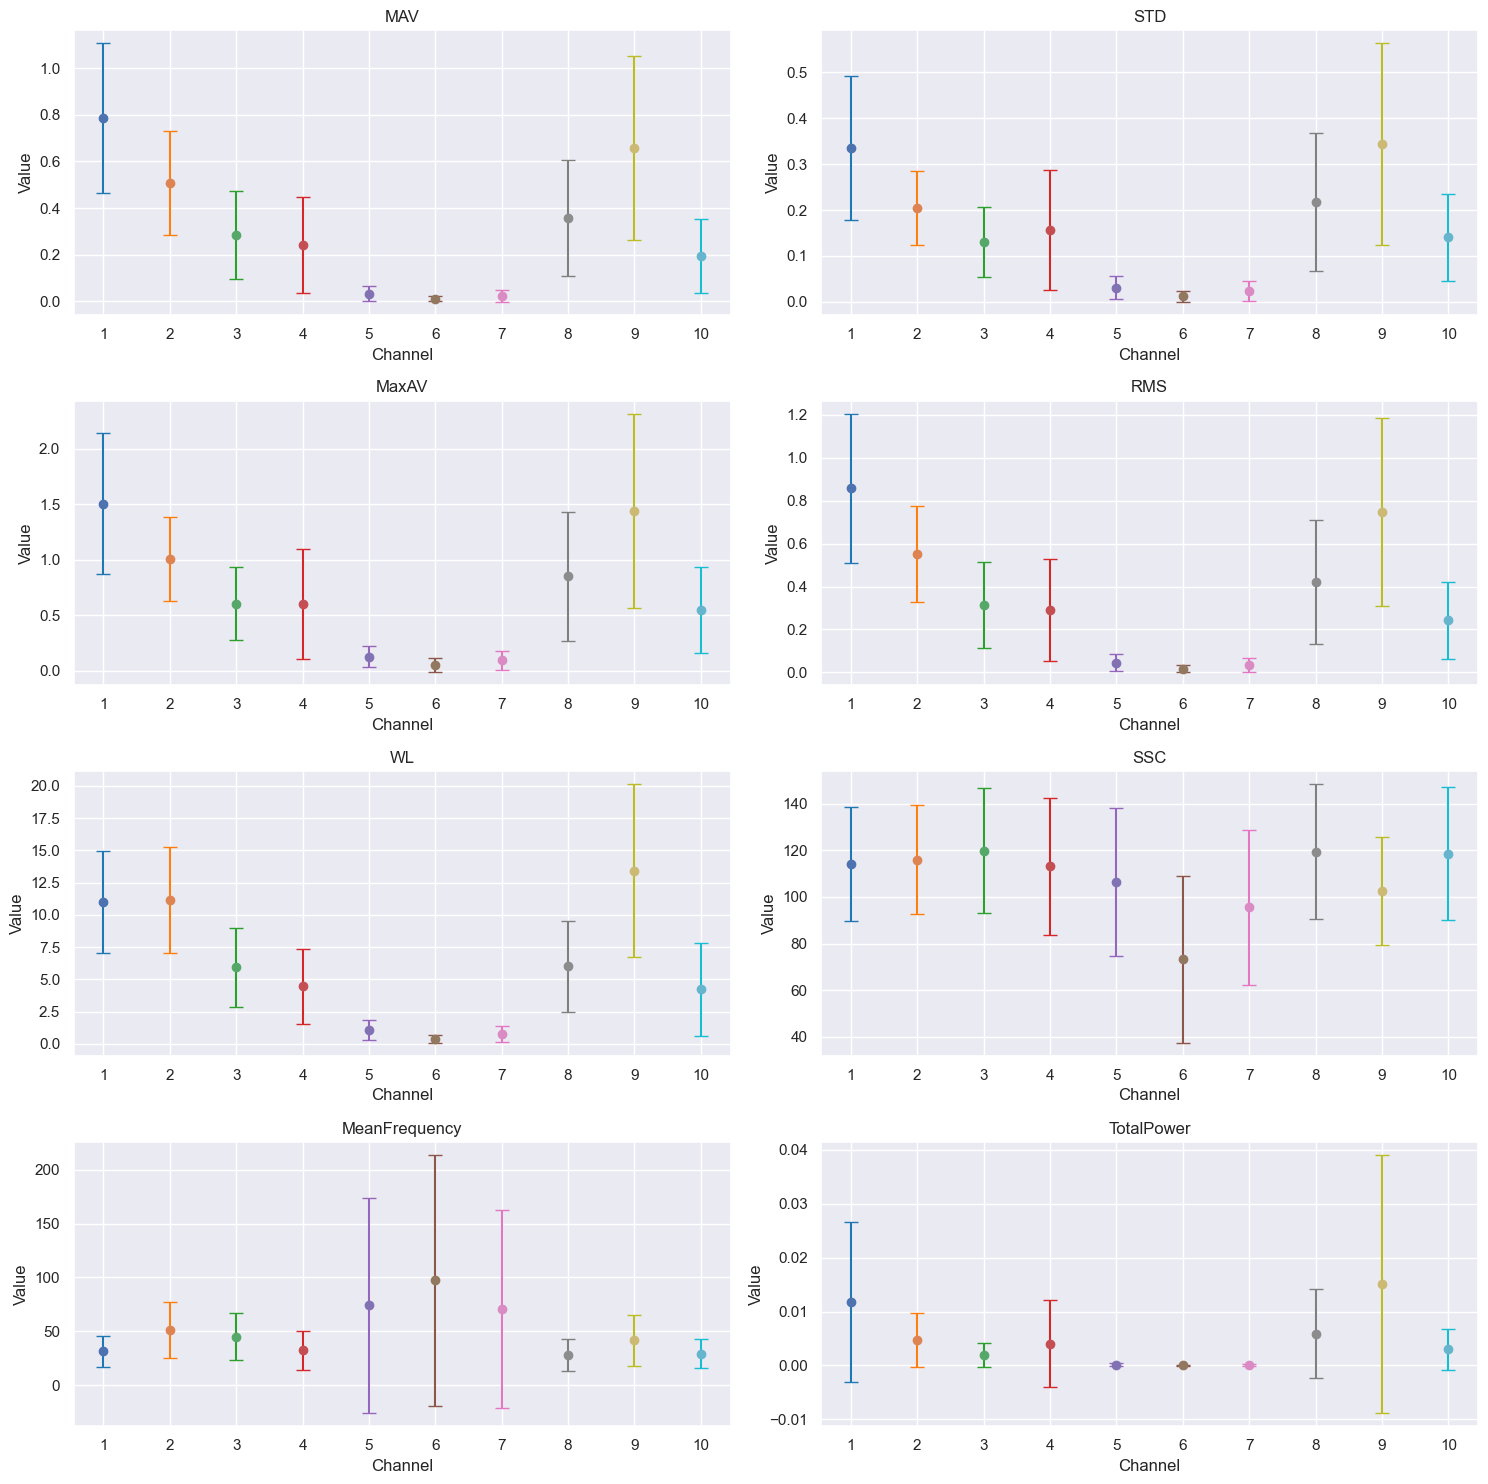

In [20]:
fig, axes = plt.subplots(4, 2, figsize=(15, 15))
axes = axes.flatten()  # Flatten the 2D array of axes to make indexing easier

for i, feature_type in enumerate(feature_types):
    ax = axes[i]
    for j in range(num_channels):
        index = j * num_feature_types + i
        ax.errorbar(j, summary_stats.loc['mean'][index], yerr=summary_stats.loc['std'][index], fmt='o', ecolor=colors(j), capsize=5, label=f'Channel {j+1}' if i == 0 else "")
    ax.set_title(f'{feature_type}')
    ax.set_xlabel('Channel')
    ax.set_ylabel('Value')
    ax.set_xticks(range(num_channels))
    ax.set_xticklabels([j+1 for j in range(num_channels)])

plt.tight_layout()
plt.show()

**Question:** 

What do you see? Are the values similar between repetitions and between channels? Explain the possible reasons for similarity/discrepancies.

**Answer:** 

In most channels, we know that the values are similar between repetitions because the mean values of the features for each channel have relatively small standard deviations, as shown by the error bars in the plots, indicating a stable and repeatable EMG signals for the same movements. 

However, there are noticeable differences in feature values between channels. These discrepancies can be attributed to factors such as variations in electrode placement, differences in muscle activation, and varying levels of signal noise, highlighting the impact of physiological and technical factors on EMG signal characteristics.

### Perform classification on the data (Random Forest)

In [21]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.3, random_state=42)

# Normalizing the data
scaler = StandardScaler()                  # Scale the features (mean of 0 and stdev of 1)
X_train_z = scaler.fit_transform(X_train)  # Fit the scaler on the training data and transform it
X_test_z = scaler.transform(X_test)        # Transform the test data using the same scaler

# Train RandomForest classifier on the normalized data
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_z, y_train)                # Fit the model on the training data

# Evaluate the classifier on the test set
y_pred = clf.predict(X_test_z)             # Predict the labels of the test set

### Evaluate performance

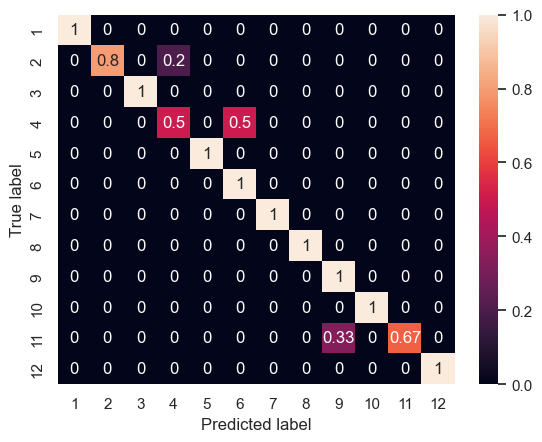

In [22]:
# Create a confusion matrix to visualize the performance of the classification
confmat = confusion_matrix(y_test, y_pred, normalize="true")
fig, ax = plt.subplots()
sns.heatmap(confmat, annot=True, ax=ax)    # Use seaborn to create a heatmap of the confusion matrix
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")
ax.set_xticklabels(range(1, len(confmat) + 1))
ax.set_yticklabels(range(1, len(confmat) + 1))
plt.show()

In [23]:
# Define the scoring metrics
scoring = {'accuracy': 'accuracy', 'f1': make_scorer(f1_score, average='weighted')}

# Perform cross-validation
cv_results = cross_validate(clf, X_train_z, y_train, cv=5, scoring=scoring)

# Print the accuracy and F1 scores
print(f"Accuracy scores of all models: {cv_results['test_accuracy']}")
print(f"Mean accuracy across all models: {np.mean(cv_results['test_accuracy'])} \n")

print(f"F1 scores of all models: {cv_results['test_f1']}")
print(f"Mean F1 score across all models: {np.mean(cv_results['test_f1'])}")

Accuracy scores of all models: [0.88235294 0.76470588 0.88235294 0.70588235 0.9375    ]
Mean accuracy across all models: 0.8345588235294118 

F1 scores of all models: [0.87254902 0.74117647 0.87254902 0.68627451 0.9375    ]
Mean F1 score across all models: 0.8220098039215686


**Question:**

Justify why the metric is suitable for this task and whether the performance is satisfactory.

**Answer:**

The F1 score is suitable for this task because it balances precision and recall, providing a single metric that accounts for both false positives and false negatives. This is particularly useful if the dataset is imbalanced, as accuracy alone might be misleading. A satisfactory performance would typically be indicated by an F1 score close to 1, suggesting a good balance between precision and recall.

### Feature selection & Dimension reduction

In [24]:
# Define the parameter grid for RandomForestClassifier
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "bootstrap": [True, False]
}

# Initialize GridSearchCV with RandomForestClassifier
grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, n_jobs=-1)
grid.fit(X_train_z, y_train)

print(f"Best estimator: {grid.best_estimator_}")
print(f"Best hyperparameters: {grid.best_params_}")

Best estimator: RandomForestClassifier(min_samples_split=5, n_estimators=200, random_state=42)
Best hyperparameters: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}


In [25]:
# Calculate mutual information between each feature and the target variable.
mutual_info = mutual_info_classif(X_train_z, y_train)
print(f"Estimated mutual information between each feature and the target:\n {mutual_info}\n")

# Select the top 30 features based on mutual information scores.
k_best = SelectKBest(mutual_info_classif, k=30)
k_best.fit(X_train_z, y_train)

# Transform the training and test datasets to only include the selected features.
X_train_best = k_best.transform(X_train_z)
X_test_best = k_best.transform(X_test_z)

# Train the RandomForestClassifier with the selected features.
clf = RandomForestClassifier(**grid.best_params_)  # Use the best parameters found before
clf.fit(X_train_best, y_train)

# Predict the labels for the test set using the trained model.
y_pred = clf.predict(X_test_best)

Estimated mutual information between each feature and the target:
 [0.6696084  0.80175373 0.87720972 0.7340876  0.75765806 0.2169233
 0.22779518 0.59194899 0.36037209 0.30543396 0.39107495 0.35426003
 0.17150502 0.1407011  0.18012224 0.34295082 0.8077568  0.73991544
 0.6082676  0.8124021  0.71326111 0.16564897 0.33951484 0.53554252
 1.01305128 0.84903924 0.80192155 0.98280646 0.85986939 0.13591625
 0.07879463 0.81637865 0.71549083 0.63145213 0.60310431 0.65839766
 0.90292202 0.31926265 0.45686184 0.55073998 0.48361641 0.54098847
 0.52481543 0.52093445 0.77343769 0.45628349 0.4043296  0.557602
 0.54875372 0.59043617 0.52994306 0.56096887 0.70362512 0.39274158
 0.39627557 0.58021433 0.69796934 0.76410106 0.68825179 0.72048511
 0.76265146 0.08720804 0.33188559 0.73073278 0.75561177 0.89891137
 0.76531395 0.81328591 0.66531196 0.12717846 0.43912906 0.91710801
 0.68067181 0.56957239 0.61313832 0.65175624 0.6674356  0.28891952
 0.22292753 0.66984243]



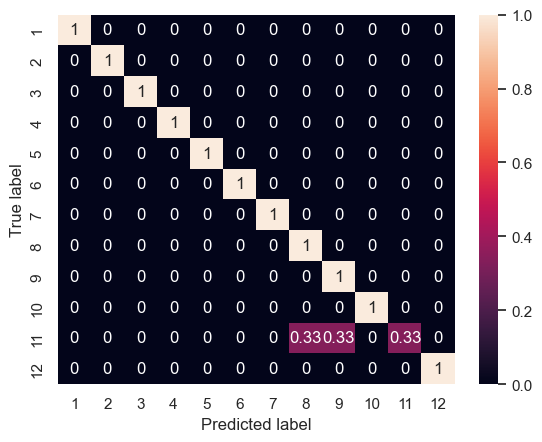

In [26]:
# Create a confusion matrix to visualize the performance of the classification model.
confmat = confusion_matrix(y_test, y_pred, normalize="true")

# Plot the confusion matrix using a heatmap for better visualization.
fig, ax = plt.subplots()
sns.heatmap(confmat, annot=True, ax=ax)
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")
ax.set_xticklabels(range(1, len(confmat) + 1))
ax.set_yticklabels(range(1, len(confmat) + 1))
plt.show()

In [28]:
# Perform cross-validation with the selected features
clf_best_features = RandomForestClassifier(**grid.best_params_)
cv_results_best_features = cross_validate(clf_best_features, X_train_best, y_train, cv=5, scoring=scoring)

# Print the accuracy and F1 scores
print(f"Accuracy scores of all models with selected features: {cv_results_best_features['test_accuracy']}")
print(f"Mean accuracy across all models with selected features: {np.mean(cv_results_best_features['test_accuracy'])} \n")

print(f"F1 scores of all models with selected features: {cv_results_best_features['test_f1']}")
print(f"Mean F1 score across all models with selected features: {np.mean(cv_results_best_features['test_f1'])}")

Accuracy scores of all models with selected features: [0.94117647 0.82352941 0.94117647 0.64705882 0.9375    ]
Mean accuracy across all models with selected features: 0.8580882352941177 

F1 scores of all models with selected features: [0.92156863 0.82352941 0.94117647 0.58431373 0.9375    ]
Mean F1 score across all models with selected features: 0.8416176470588235


### Feature selection & Dimension reduction (other idea)

One could also apply other feature selection and dimension reduction methods to assess the accuracy and F1 score of our model:

In [29]:
# Perform L1-based feature selection using Logistic Regression
log_reg = LogisticRegression(C=1.0, penalty='l1', solver='liblinear')
log_reg.fit(X_train_z, y_train)

# Select features based on the L1 regularization
model = SelectFromModel(log_reg, prefit=True)
X_train_l1 = model.transform(X_train_z)
X_test_l1 = model.transform(X_test_z)

# Perform PCA to reduce the dimensionality of the dataset
pca = PCA(n_components=30)
X_train_pca = pca.fit_transform(X_train_l1)
X_test_pca = pca.transform(X_test_l1)

# Train the RandomForestClassifier with the PCA-transformed features
clf_combined = RandomForestClassifier(**grid.best_params_)
clf_combined.fit(X_train_pca, y_train)

# Predict the labels for the test set using the trained model
y_pred_combined = clf_combined.predict(X_test_pca)

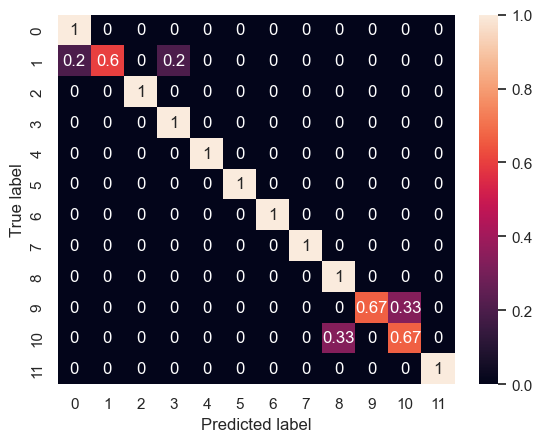

In [30]:
# Create a confusion matrix to visualize the performance of the classification model.
confmat = confusion_matrix(y_test, y_pred_combined, normalize="true")

# Plot the confusion matrix using a heatmap for better visualization.
fig, ax = plt.subplots()
sns.heatmap(confmat, annot=True, ax=ax)
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")
plt.show()

In [31]:
# Perform cross-validation with the L1-based feature selection and PCA-transformed features
clf_combined = RandomForestClassifier(**grid.best_params_)
cv_results_combined = cross_validate(clf_combined, X_train_pca, y_train, cv=5, scoring=scoring)

# Print the accuracy and F1 scores
print(f"Accuracy scores of all models with L1-based feature selection and PCA: {cv_results_combined['test_accuracy']}")
print(f"Mean accuracy across all models with L1-based feature selection and PCA: {np.mean(cv_results_combined['test_accuracy'])} \n")

print(f"F1 scores of all models with L1-based feature selection and PCA: {cv_results_combined['test_f1']}")
print(f"Mean F1 score across all models with L1-based feature selection and PCA: {np.mean(cv_results_combined['test_f1'])}")

Accuracy scores of all models with L1-based feature selection and PCA: [0.88235294 0.70588235 0.94117647 0.82352941 1.        ]
Mean accuracy across all models with L1-based feature selection and PCA: 0.8705882352941176 

F1 scores of all models with L1-based feature selection and PCA: [0.87843137 0.68235294 0.91764706 0.78039216 1.        ]
Mean F1 score across all models with L1-based feature selection and PCA: 0.851764705882353


**Question:**

Evaluate the performance using the same metric as point 5. Is there an improvement in the performance?

**Answer:**

There is indeed a little improvement in the performance, as we go from mean accuracy and F1 scores across all orginal model of 0.811 and 0.788 respectively, to mean accuracy and F1 scores across all models with 30 best features of 0.823 and 0.792 respectively, and even mean accuracy and F1 scores across all models with L1-based feature selection and PCA of 0.847 and 0.836 respectively.